# Lab CMBLenses

In [1]:
using Pkg
Pkg.activate(".")
Pkg.precompile()

  Activating project at `/global/u2/j/jaimerz/PhD/CMBLensingInferenceTestProblem/examples`


In [2]:
using Revise, Adapt, CMBLensing, CMBLensingInferenceTestProblem, CUDA, JLD2, LaTeXStrings, NPZ, 
    LinearAlgebra, MCMCChains, MCMCDiagnosticTools, MuseInference, MicroCanonicalHMC,
    Plots, ProgressMeter, Random, Statistics, Zygote 

┌ Warning: CUDA runtime library libcublasLt.so.12 was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA ~/.julia/packages/CUDA/35NC6/src/initialization.jl:171
┌ Warning: CUDA runtime library libnvJitLink.so.12 was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA ~/.julia/packages/CUDA/35NC6/src/initialization.jl:171
┌ Warning: CUDA runtime library libcusparse.so.12 was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA ~/.julia/packages/CUDA/35NC6/src/initialization.jl:171


In [3]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [4]:
Nside = 64
T = Float64;
use_map = true
masking = false
t = nothing
precond_path = string("../pixel_preconditioners/pp_nside_", Nside, "_t_", t)
println("Nside: ", Nside)
println("Use Map: ", use_map)
println("Masking: ", masking)


Nside: 64
Use Map: true
Masking: false


In [5]:
prob = load_cmb_lensing_problem(;storage=CuArray, T, Nside,
    masking=masking, global_parameters=true);
d = length(prob.Ωstart)

prob_cpu = load_cmb_lensing_problem(;storage=Array, T, Nside,
    masking=masking, global_parameters=true);
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob_cpu.Ωstart);

cl = get_Cℓ(prob.Ωstart[:ϕ°][:I]);
println("Built problem")

Built problem


In [6]:
# Precond
prob.Λmass.diag.θ.r *= 5.85
prob.Λmass.diag.θ.Aϕ *= 112.09

if t == nothing
    precond = one(simulate(Diagonal(one(LenseBasis(diag(prob.Λmass))))));
else
    precond = load(precond_path, "dist_mat_precond")
    precond = adapt(CuArray, precond)
    precond = from_vec(precond);
end
;

In [7]:
#init_params
if use_map
    println("Strating from the map")
    init_params = prob.Ωtrue
else
    println("Strating from the starting point")
    init_params = prob.Ωstart
end
;

Strating from the map


# MCHMC

In [8]:
function CMBLensingTarget(prob; kwargs...)
    θ_start = prob.Ωstart
    Λmass = prob.Λmass
    sqrtΛmass = sqrt(Λmass)
    inv_sqrtΛmass = pinv(sqrtΛmass)

    transform(θ) = CMBLensing.LenseBasis(sqrtΛmass * θ)
    inv_transform(x) = CMBLensing.LenseBasis(inv_sqrtΛmass * x)
    ℓπ(x) = prob(inv_transform(x))
    ∂lπ∂x(x) = (ℓπ(x), CMBLensing.LenseBasis(Zygote.gradient(ℓπ, x)[1]))

    return MicroCanonicalHMC.CustomTarget(
        ℓπ,
        ∂lπ∂x,
        θ_start;
        transform=transform,
        inv_transform=inv_transform,
        kwargs...)
end

target = CMBLensingTarget(prob);

In [21]:
#Sampler
TEV = 0.000001
nadapts = 0
n_mchmc = 20_000
L=70.0
spl = MCHMC(nadapts, TEV;
    adaptive=true, eps=10.0, L=L, sigma=precond,
    tune_L=false, tune_sigma=false);

In [22]:
fol_name=string("/pscratch/sd/j/jaimerz/new_chains/", Nside,"/MCHMC",
    "_Nside_", Nside,
    "_use_map_", use_map,
    "_masking_", masking,
    "_precond_", t,
    "_L_", L,
    "_TEV_", TEV)

last_n = 0 
if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("chain", file)])
        last_n = parse(Int, last_chain[end])
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
end

file_name = string(fol_name, "/chain_", last_n+1, "_", n_mchmc)

Created new folder /pscratch/sd/j/jaimerz/new_chains/512/MCHMC_Nside_512_use_map_true_masking_false_precond_nothing_L_70.0_TEV_1.0e-6


"/pscratch/sd/j/jaimerz/new_chains/512/MCHMC_Nside_512_use_map_true_masking_false_precond_nothing_L_70.0_TEV_1.0e-6/chain_1_20000"

In [23]:
prob.ncalls[] = 0
samples_mchmc = MicroCanonicalHMC.Sample(spl, target, n_mchmc; init_params=init_params, include_latent=true, thinning=5, file_name=file_name)
ncalls_mchmc = prob.ncalls[]

[ Info: Using provided init_params
[ Info: Tuning eps ⏳


LoadError: Out of GPU memory trying to allocate 46.875 GiB
Effective GPU memory usage: 99.99% (79.142 GiB/79.154 GiB)
Memory pool usage: 47.185 GiB (78.656 GiB reserved)


In [24]:
chain_mchmc = Chains(permutedims(reduce(hcat, [Array([exp.(sample[end÷2-2:end÷2-1]); sample[end-2:end]]) for sample in eachcol(samples_mchmc) if all(isfinite.(sample))])),  [:r, :Aϕ, :eps, :dE, :logpdf]);


In [25]:
ess_mchmc = MCMCDiagnosticTools.ess(chain_mchmc)[[:r,:Aϕ],:ess]

2-element Vector{Float64}:
  52.2575088834704
 107.15796920092676

In [26]:
ess_per_call_mchmc = ess_mchmc ./ n_mchmc #ncalls_mchmc

2-element Vector{Float64}:
 0.00261287544417352
 0.005357898460046338

In [27]:
fol_name=string("../summaries/unmasked/MCHMC_summaries",
    "_Nside_", Nside,
    "_use_map_", use_map,
    "_masking_", masking,
    "_precond_", t,
    "_L_", L,
    "_TEV_", TEV)

if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("hyperparams", file)])
        last_n = parse(Int, last_chain[end-4])
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
end

file_name = string(fol_name, "/hyperparams_", last_n+1, "_", n_mchmc, ".npz" )
npzwrite(file_name, Dict(
        "r"=> vec(chain_mchmc[:r])[:],
        "Aphi"=> vec(chain_mchmc[:Aϕ])[:],
        "eps":=> vec(chain_mchmc[:eps])[:]))

file_name = string(fol_name, "/ESS_", last_n+1, "_", n_mchmc, ".npz" )
npzwrite(file_name,
    Dict("ESS"=> ess_mchmc,
         "ESS_per_lkl" =>  ess_per_call_mchmc))

Created new folder ../summaries/unmasked/MCHMC_summaries_Nside_512_use_map_true_masking_false_precond_nothing_L_70.0_TEV_1.0e-6


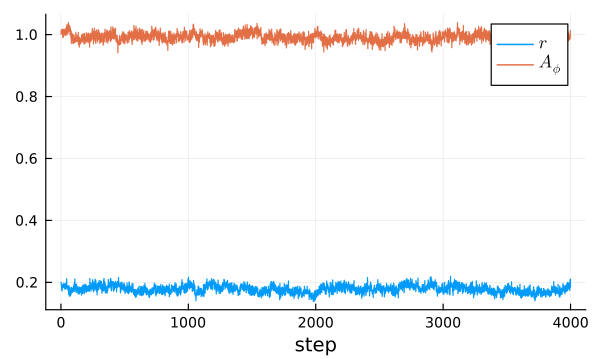

In [16]:
plot(chain_mchmc[:r], label=L"r", xlabel="step")
plot!(chain_mchmc[:Aϕ], label=L"A_\phi")

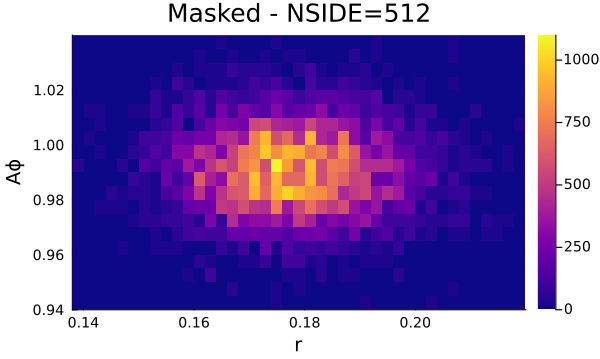

In [17]:
histogram2d(chain_mchmc[:r], chain_mchmc[:Aϕ], bins=(40, 20), show_empty_bins=true,
    normalize=:pdf, color=:plasma)
title!(string("Masked - NSIDE=", Nside))
ylabel!("Aϕ")
xlabel!("r")

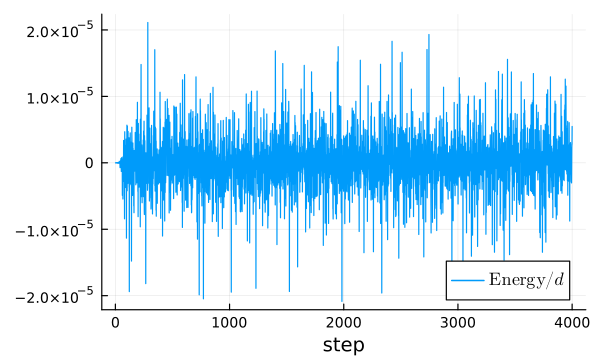

In [18]:
plot(chain_mchmc[:dE]/d, label=L"\mathrm{Energy}/d", xlabel="step")

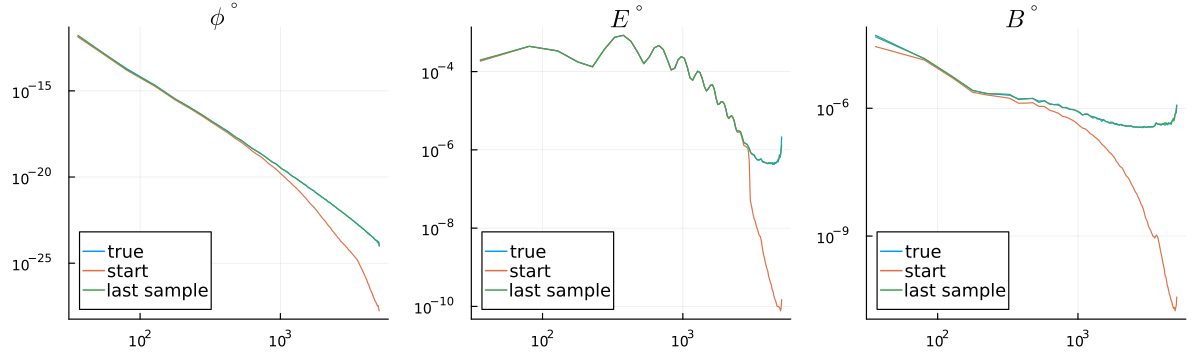

GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27


In [19]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(adapt(Array, from_vec(samples_mchmc[:, end]))[k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)
     

In [20]:
cls = zeros(3, length(get_Cℓ(prob.Ωstart[:ϕ°])[:]), size(samples_mchmc)[2])
fields = [[:ϕ°, :I], [:f°,:E,], [:f°,:B]]
for j in 1:3
    f1, f2 = fields[j]
    for i in 1:size(samples_mchmc)[2]
        cls[j,:,i] = get_Cℓ(adapt(Array, from_vec(samples_mchmc[:, i]))[f1][f2])[:]
    end
end 

phi_cls, E_cls, B_cls = cls[1,:,:], cls[2,:,:], cls[3,:,:]
phi_cls_m, phi_cls_s = mean(phi_cls, dims=2)[:], std(phi_cls, dims=2)[:]
E_cls_m, E_cls_s = mean(E_cls, dims=2)[:], std(E_cls, dims=2)[:]
B_cls_m, B_cls_s = mean(B_cls, dims=2)[:], std(B_cls, dims=2)[:]


file_name = string(fol_name, "/cls_", last_n+1, "_", n_mchmc, ".npz" )
npzwrite(file_name,
    Dict("phi_cls_m"=> phi_cls_m,
          "phi_cls_s"=> phi_cls_s,
          "E_cls_m"=> E_cls_m,
          "E_cls_s"=> E_cls_s,
          "B_cls_m"=> B_cls_m,
          "B_cls_s"=> B_cls_s))

# HMC

In [8]:
samples_hmc = []
rng = Xoshiro(1)
prob.ncalls[] = 0
ϵ=0.01
N=25
n_hmc = 1300
@showprogress for i=1:n_hmc
    Ω, = state = hmc_step(rng, prob, init_params, prob.Λmass; symp_kwargs=[(N=N, ϵ=ϵ)], progress=false, always_accept=(i<10))
    push!(samples_hmc, adapt(Array, state))
end
ncalls_hmc = prob.ncalls[]

Progress: 100%|█████████████████████████████████████████| Time: 0:19:32


36400

In [9]:
chain_hmc = Chains(
    permutedims(reduce(hcat, [exp.(sample[1].θ) for sample in samples_hmc])),
    [:r, :Aϕ],
);

In [10]:
_samples_hmc = zeros(n_hmc, 3*Nside^2+2)
for i in 1:n_hmc
    _samples_hmc[i, :]  = samples_hmc[i][1][:]
end

In [12]:
fol_name=string("/pscratch/sd/j/jaimerz/new_chains/", Nside, "/HMC",
    "_use_map_", use_map,
    "_masking_", masking,
    "_Nside_", Nside,
    "_N_", N,
    "_ϵ_", ϵ)

if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("chain", file)])
        last_n = parse(Int, last_chain[end])
    else
        println("Starting new chain")
        last_n = 0
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
    last_n = 0
end

file_name = string(fol_name, "/chain_", last_n+1, "_", (ncalls_hmc/2))

@save file_name _samples_hmc

Found existing file /pscratch/sd/j/jaimerz/new_chains/64/HMC_use_map_true_masking_false_Nside_64_N_25_ϵ_0.01


In [14]:
ess_hmc = MCMCDiagnosticTools.ess(chain_hmc)[[:r,:Aϕ],:ess]

2-element Vector{Float64}:
 1227.7154981538974
 1219.4869703650488

In [15]:
ess_per_call_hmc = ess_hmc ./ (ncalls_hmc/2)

2-element Vector{Float64}:
 0.0674568955029614
 0.0670047785914862

In [27]:
fol_name=string("../summaries/unmasked/HMC_summaries",
    "_use_map_", use_map,
    "_masking_", masking,
    "_Nside_", Nside,
    "_N_", N,
    "_ϵ_", ϵ)

if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("hyperparams", file)])
        last_n = parse(Int, last_chain[end-4])
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
end

file_name = string(fol_name, "/hyperparams_", last_n+1, "_", Int(ncalls_hmc/2), ".npz" )
npzwrite(file_name,
    Dict("r"=> vec(chain_hmc[:r])[:],
    "Aphi"=> vec(chain_hmc[:Aϕ])[:]))

file_name = string(fol_name, "/ESS_", last_n+1, "_", Int(ncalls_hmc/2), ".npz" )
npzwrite(file_name,
    Dict("ESS"=> ess_hmc,
         "ESS_per_lkl" =>  ess_per_call_hmc))

Found existing file ../summaries/unmasked/HMC_summaries_use_map_true_masking_false_Nside_64_N_25_ϵ_0.01


## Plot

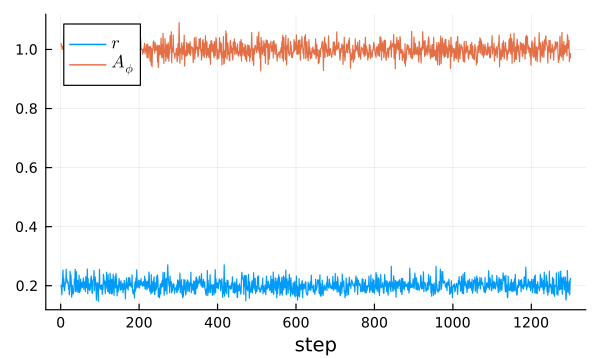

In [16]:
plot([exp(Ω.θ.r) for (Ω,) in samples_hmc], label=L"r", xlabel="step")
plot!([exp(Ω.θ.Aϕ) for (Ω,) in samples_hmc], label=L"A_\phi")     


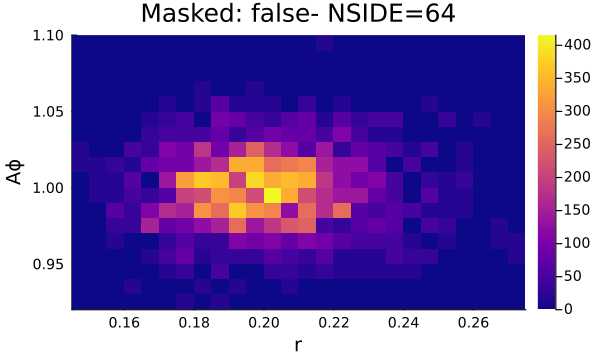

In [17]:
histogram2d(chain_hmc[:r], chain_hmc[:Aϕ], bins=(40, 20), show_empty_bins=true,
    normalize=:pdf, color=:plasma)
title!(string("Masked: ", masking, "- NSIDE=", Nside))
ylabel!("Aϕ")
xlabel!("r")

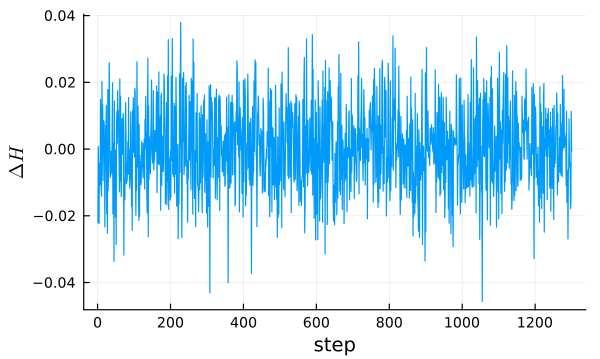

In [18]:
plot(getindex.(samples_hmc, 2), label=nothing, xlabel="step", ylabel=L"\Delta H")     

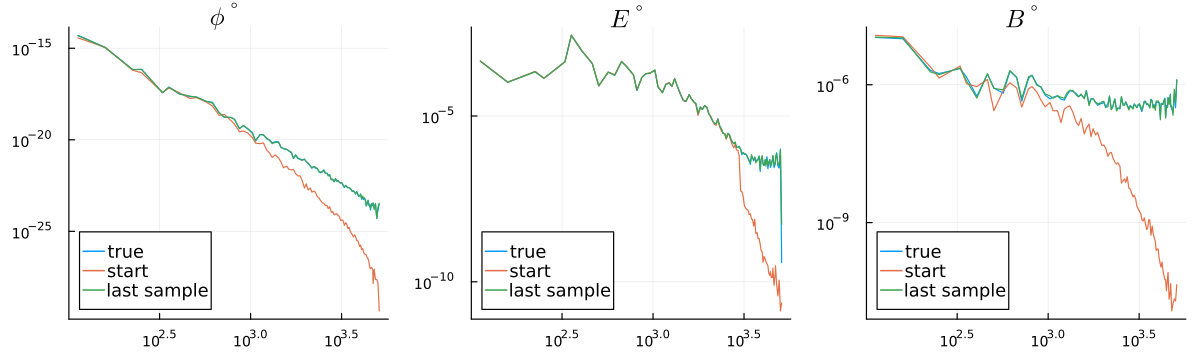

GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27


In [19]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(samples_hmc[end][1][k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)
     


In [28]:
cls = zeros(3, length(get_Cℓ(prob.Ωstart[:ϕ°])[:]), length(samples_hmc))
fields = [[:ϕ°, :I], [:f°,:E,], [:f°,:B]]
for j in 1:3
    f1, f2 = fields[j]
    for i in 1:length(samples_hmc)
        cls[j,:,i] = get_Cℓ(samples_hmc[i][1][f1][f2])[:]
    end
end 

phi_cls, E_cls, B_cls = cls[1,:,:], cls[2,:,:], cls[3,:,:]
phi_cls_m, phi_cls_s = mean(phi_cls, dims=2)[:], std(phi_cls, dims=2)[:]
E_cls_m, E_cls_s = mean(E_cls, dims=2)[:], std(E_cls, dims=2)[:]
B_cls_m, B_cls_s = mean(B_cls, dims=2)[:], std(B_cls, dims=2)[:]


file_name = string(fol_name, "/cls_", last_n+1, "_", Int(ncalls_hmc/2), ".npz" )
npzwrite(file_name,
    Dict("phi_cls_m"=> phi_cls_m,
          "phi_cls_s"=> phi_cls_s,
          "E_cls_m"=> E_cls_m,
          "E_cls_s"=> E_cls_s,
          "B_cls_m"=> B_cls_m,
          "B_cls_s"=> B_cls_s))

In [37]:
cl = get_Cℓ(prob.Ωstart[:ϕ°])
cl.ℓ

98-element Vector{Float64}:
  112.5
  159.0990257669732
  225.0
  251.55764746872637
  328.1326913068022
  355.7562367689427
  405.6245184896988
  463.9496104092386
  503.1152949374527
  567.0083619712457
  616.3561322585743
  671.3617410717869
  715.959237997992
    ⋮
 4418.17527153051
 4466.133254959287
 4530.299095845991
 4557.298307324579
 4622.557423626369
 4696.791565488783
 4710.244818478122
 4776.948244333811
 4854.911151340149
 4933.352855315039
 5012.25061723773
 5091.168824543142

# MUSE

In [8]:
using CMBLensing.ComponentArrays, MuseInference.FiniteDifferences

In [9]:
muse_prob = CMBLensingMuseProblem(
    prob.ds, 
    MAP_joint_kwargs = (minsteps=3, nsteps=15, αtol=1e-2, gradtol=3e-5, progress=false, history_keys=(:logpdf, :ΔΩ°_norm)),
);

In [10]:
# small hack to allow getting MUSE covariance in terms of transformed θ
CMBLensingMuseInferenceExt = Base.get_extension(CMBLensing,:CMBLensingMuseInferenceExt)
CMBLensingMuseInferenceExt.mergeθ(prob::CMBLensingMuseInferenceExt.CMBLensingMuseProblem, θ) = exp.(θ)

In [11]:
# z₀ = zero(FieldTuple(MuseInference.select(NamedTuple(prob.Ωstart), (:f°, :ϕ°))))
# H_pre = Diagonal(FieldTuple(MuseInference.select(NamedTuple(prob.Λmass.diag), (:f°, :ϕ°))))
# H_pre_map = let H_pre=H_pre, z₀=z₀
#     MuseInference.LinearMap{eltype(z₀)}(length(z₀), issymmetric=true) do z
#         f, = promote(z, z₀)
#         LenseBasis(H_pre \ f)[:]
#     end
# end
# implicit_diff_cg_kwargs = (maxiter=1500,Pl=MuseInference.InverseMap(H_pre_map));

In [12]:
z₀ = zero(MuseInference.sample_x_z(muse_prob, Xoshiro(0), prob.Ωstart.θ).z);
result = MuseResult()
nsims = 200
rng = Xoshiro(0)

prob.ncalls[] = 0
MuseInference.muse!(result,  muse_prob, prob.Ωstart.θ; nsims, rng, z₀, maxsteps=2, θ_rtol=0, progress=true, save_MAPs=false)
MuseInference.get_J!(result, muse_prob; nsims,   rng, z₀, progress=true)
MuseInference.get_H!(result, muse_prob; nsims=4, rng, z₀, progress=true, step=std(result.gs)/100, fdm=central_fdm(2,1,adapt=0))
ncalls_muse = prob.ncalls[];

MUSE: 100%|█████████████████████████████████████████████| Time: 0:04:06
get_H: 100%|████████████████████████████████████████████| Time: 0:00:13


In [13]:
chain_muse = Chains(permutedims(rand(result.dist,5_000)), [:logr, :logAϕ]);

KeyError: KeyError: key "usage_request" not found

In [14]:
ncalls_muse

15953

In [ ]:
fol_name=string("/pscratch/sd/j/jaimerz/chains/", Nside, "/MUSE/CMBLensing",
    "_cosmo_", global_parameters,
    "_masking_", masking,
    "_Nside_", Nside)
@save fol_name chain_muse

In [ ]:
#chain_muse = load("../chains/MUSE/CMBLensing_masked_Nnside_64", "chain_muse")

In [ ]:
ess_per_call_muse = nsims / ncalls_muse

## Plot

# Compare

In [ ]:
ess_per_call_muse ./ minimum(ess_per_call_hmc)

In [ ]:
ess_per_call_muse ./ minimum(ess_per_call_mchmc)

In [ ]:
ess_per_call_mchmc

In [ ]:
ess_per_call_hmc

In [ ]:
ess_per_call_muse

In [ ]:
which_ess = minimum # can be: first (r), last (Aphi), or minimum
bar(
    ["HMC" "MCHMC" "MUSE"],
    which_ess.([[ess_per_call_hmc] [ess_per_call_mchmc] [ess_per_call_muse]]),
    ylabel = "eff. samples / ∇logP eval", legend=false)

In [ ]:
plot(
    begin
        histogram(log.(chain_hmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MCHMC")
        histogram!(chain_muse[:logr], normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.r], c=4, lw=3, label="Truth")
    end, 
    begin
        histogram(log.(chain_hmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MCHMC")
        histogram!(chain_muse[:logAϕ], normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.Aϕ], c=4, lw=3, label="Truth")
    end, 
    size = (700, 300)
)